### Step 1 Import libraries and the dataset

Here we use the Online Retail Dataset from Kaggle. Online Retail is a transactional dataset which contains data all the transactions happened between 2010 and 2011 for a UK based and registeres non-store online retail.

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA

data = pd.read_csv("C:/Users/soas/Downloads/archive/OnlineRetail.csv",encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Step 2 Feature Engineering

In [3]:
# check for Null values
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# we need to remove all rows where customerID is null
data = data.dropna()
data.isnull().sum()

data.shape

(406829, 8)

In [6]:
# To support calculation of new features, let's change the datatype of 'InvoiceDate' to datetime format

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Chenage the datetype of 'CustomerID' to string

data['CustomerID'] = data['CustomerID'].astype(str)

In [7]:
# Create a new column that shows the total amount paid
data['AmountPaid'] = data['UnitPrice'] * data['Quantity']
data.describe()

,Quantity,UnitPrice,AmountPaid
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854
std,248.693370,69.315162,427.591718
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.200000
50%,5.000000,1.950000,11.100000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


In [8]:
# For our evaluation, we will exclude the return orders. So, any negative quantity is the return orders. Let's exclude them.

data = data[data['Quantity']>0]


### Step 3 RFM Computation

RFM stands for Recency, Frequency and Monetory

Recency - How recently a customer has made a purchase?
Frequency - How often a customer makes a purchase?
Monetory - How much money a customer spends on purchases?

In [9]:
#Computing 
    #Recency by identifying the minimum datediff for each customer
    #Frequency by counting the number of transactions for each customer
    # Computing Average monetory by adding the total amount paid by each customer

max_date = max(data['InvoiceDate'])

data['datediff'] = max_date - data['InvoiceDate']

recency = data.groupby(['CustomerID'], as_index=False)['datediff'].min()

frequency = data.groupby(['CustomerID'], as_index=False)['InvoiceNo'].nunique()

monetory = data.groupby(['CustomerID'], as_index=False)['AmountPaid'].sum()

In [10]:
data[data['CustomerID'] == '17850.0']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AmountPaid,datediff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,697 days 08:53:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,697 days 08:53:00
...,...,...,...,...,...,...,...,...,...,...
4540,536790,22752,SET 7 BABUSHKA NESTING BOXES,4,2010-02-12 15:26:00,7.65,17850.0,United Kingdom,30.60,666 days 01:53:00
4541,536790,22803,IVORY EMBROIDERED QUILT,3,2010-02-12 15:26:00,35.75,17850.0,United Kingdom,107.25,666 days 01:53:00
4542,536790,21730,GLASS STAR FROSTED T-LIGHT HOLDER,12,2010-02-12 15:26:00,4.25,17850.0,United Kingdom,51.00,666 days 01:53:00
4543,536791,22632,HAND WARMER RED POLKA DOT,12,2010-02-12 15:27:00,1.85,17850.0,United Kingdom,22.20,666 days 01:52:00


In [11]:
# let's create a new table with the new features for each customerID

recency_frequency = recency.merge(frequency,on='CustomerID', how='inner')

rfm_data = recency_frequency.merge(monetory,on='CustomerID', how='inner')

rfm_data = rfm_data.rename({'datediff': 'Recency','InvoiceNo' : 'Frequency', 'AmountPaid' : 'Monetary'},axis=1)

rfm_data['Recency'] = rfm_data['Recency'].dt.days

#rfm_data['AVO'] = rfm_data['Monetary']/rfm_data['Frequency']

rfm_data =rfm_data[['Recency','Frequency','Monetary']]

In [12]:
rfm_data.describe().round(1)

,Recency,Frequency,Monetary
count,4339.0,4339.0,4339.0
mean,105.4,4.3,2053.8
std,115.1,7.7,8988.2
min,0.0,1.0,0.0
25%,22.0,1.0,307.2
50%,61.0,2.0,674.4
75%,161.5,5.0,1661.6
max,697.0,210.0,280206.0


### Step 4 Data Preprocessing

#### 4.1 Functions for data analysis

In [13]:
############################################
def remove_outliers(df, method = 'IRQ'):
    '''
    take dataframe and select only numerical columns
    clean outliers based on IQR by iterating over all features
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df.select_dtypes(include=numerics)
    features = newdf.columns.tolist()
   
    if method == 'IRQ':
        for _ in newdf.columns:

            Quantile1 = newdf[_].quantile(0.25)
            Quantile3 = newdf[_].quantile(0.75)
            IQR = Quantile3 - Quantile1
            
            newdf = newdf[(newdf[_] >= Quantile1 - 1.5*IQR) & (newdf[_] <= Quantile3 + 1.5*IQR)]
    elif method == '5_95':
        
        for _ in newdf.columns:
            Quantile_05 = newdf[_].quantile(0.05)
            Quantile_95 = newdf[_].quantile(0.95)
            newdf = newdf[(newdf[_] >= Quantile_05) & (newdf[_] <= Quantile_95)]
    else:
        print('something is wrong')
        pass 
    return newdf
    
############################################

def print_df(df, method = 'boxplot'):
    '''
    take dataframe, select only numerical columns and print one by one given a method specified
    '''
 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df.select_dtypes(include=numerics)
    features = newdf.columns.tolist()
    fig, ax = plt.subplots(1, len(features), figsize=(20,4))
    
    for i in range(len(features)):
        
        ax[i].set_title(features[i], fontsize = '18')
        
        if method == 'boxplot':
            ax[i].boxplot(newdf[features[i]])
        
        elif method == 'histogram':
            sns.histplot(newdf, x = features[i],  kde=True, ax=ax[i], bins = 100)
    plt.show()
    
    pass

#### 4.2 Preprocessing

In [14]:
#########################

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
rfm_ss_wo = scalar.fit_transform(rfm_data)
rfm_ss_wo = pd.DataFrame(rfm_ss_wo, columns = ['Recency','Frequency','Monetary'])

#########################

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
rfm_ss_no_95 = remove_outliers(rfm_data, method = '5_95')
rfm_ss_no_95 = scalar.fit_transform(rfm_ss_no_95)
rfm_ss_no_95 = pd.DataFrame(rfm_ss_no_95, columns = ['Recency','Frequency','Monetary'])

#########################

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
rfm_ss_no_irq = remove_outliers(rfm_data, method = 'IRQ')
rfm_ss_no_irq = scalar.fit_transform(rfm_ss_no_irq)
rfm_ss_no_irq = pd.DataFrame(rfm_ss_no_irq, columns = ['Recency','Frequency','Monetary'])
                      
#########################

from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'box-cox')
rfm_pt = remove_outliers(rfm_data, method = 'IRQ')
rfm_pt = pt.fit_transform(rfm_pt.apply(lambda x: x + 0.000001))
rfm_pt = pd.DataFrame(rfm_pt, columns = ['Recency','Frequency','Monetary'])

ORIGINAL DATA


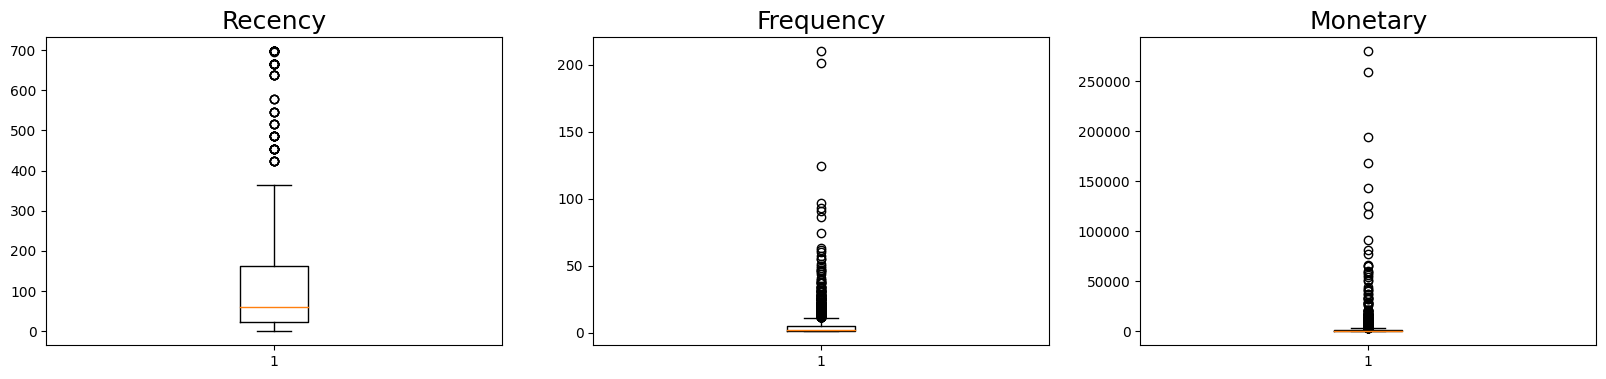

Standard Scaler with outliers


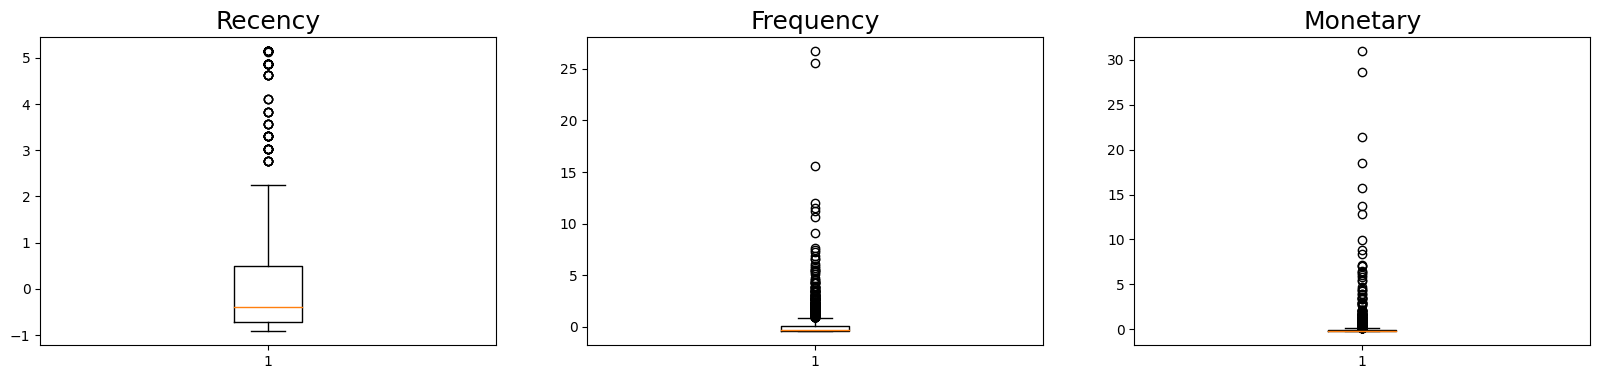

Standard Scaler with outliers removed IQR


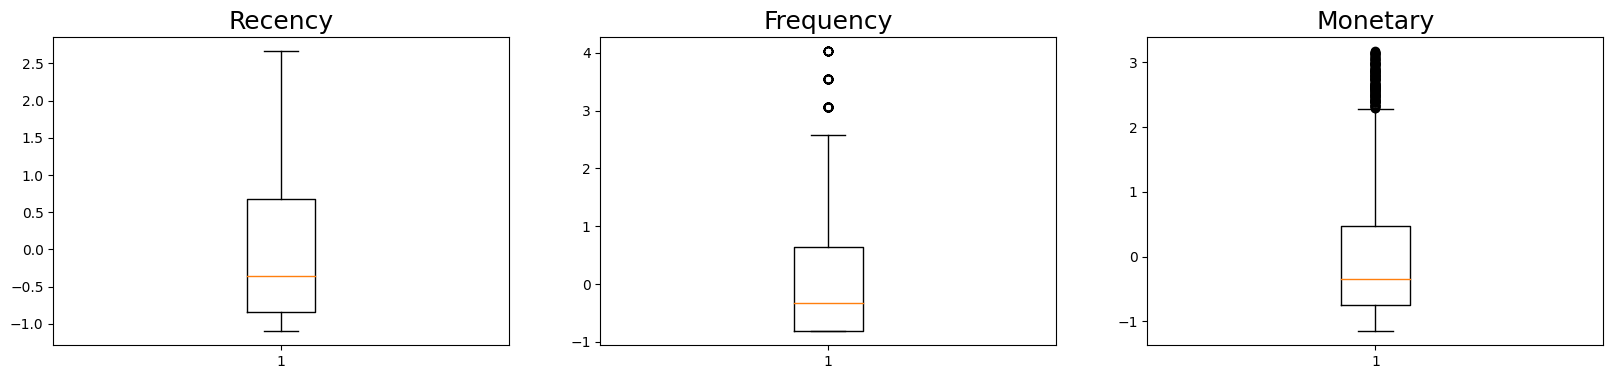

Standard Scaler with outliers removed 05_95


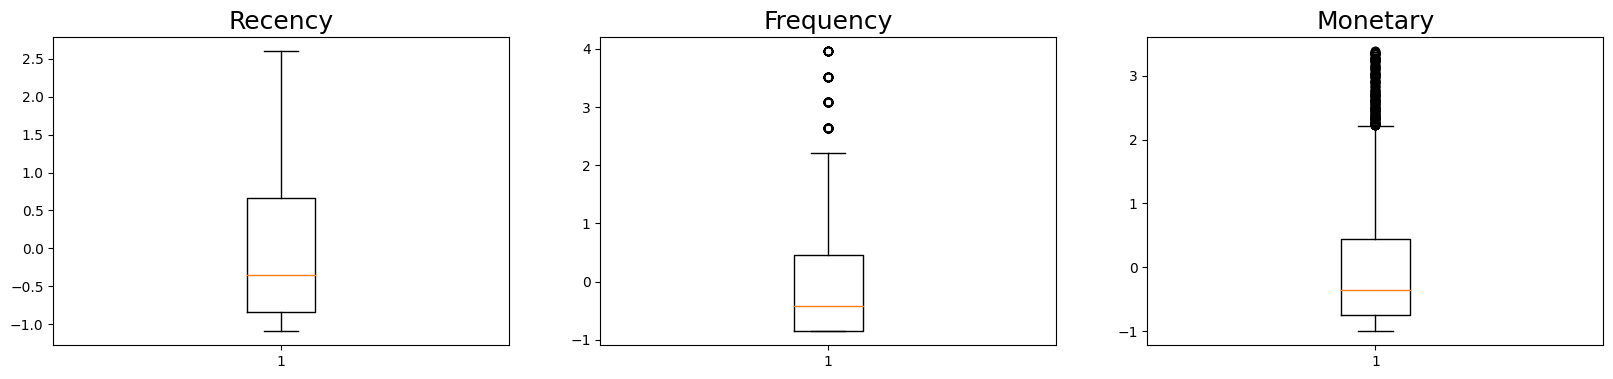

Power Transformer


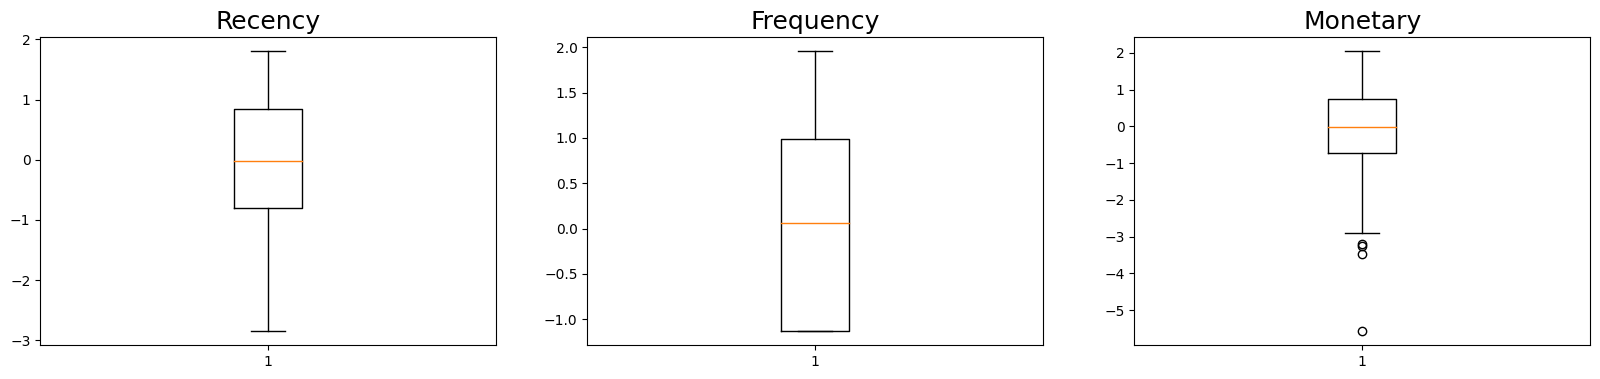

In [15]:
print('ORIGINAL DATA')
print_df(rfm_data, 'boxplot')

print('Standard Scaler with outliers')
print_df(rfm_ss_wo, 'boxplot')

print('Standard Scaler with outliers removed IQR')
print_df(rfm_ss_no_irq, 'boxplot')

print('Standard Scaler with outliers removed 05_95')
print_df(rfm_ss_no_95, 'boxplot')

print('Power Transformer')
print_df(rfm_pt, 'boxplot')

we wrill use standard scaler with outliers removed using IQR

### Step 5 Naive clustering

In [16]:
def get_rfm_rank_scores(df):
    '''
    split RFM variable by quartiles
    '''
    df_ = df.copy()
    df_['Recency_score'] = pd.qcut(df_['Recency'],5,labels = [5, 4, 3, 2, 1])
    df_['Frequency_score'] = pd.qcut(df_['Frequency'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
    df_['Monetary_score'] = pd.qcut(df_['Monetary'], 5, labels = [1, 2, 3, 4, 5])
    df_['RFM'] = df_['Recency_score'].astype(str) + df_['Frequency_score'].astype(str)
    
    return df_

rfm_naive  = get_rfm_rank_scores(rfm_ss_no_irq)

In [17]:
segment_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm_naive['segment'] = rfm_naive['RFM'].replace(segment_map, regex = True)


In [18]:
#rfm_ss_no_95['test'].value_counts()

X = rfm_naive[['Recency','Frequency', 'Monetary']]
labels_naive = rfm_naive['segment']

print(f'Silhouette Score: {round(silhouette_score(X, labels_naive), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(X, labels_naive), 3)}')



Silhouette Score: 0.008
Davies Bouldin Index: 2.669


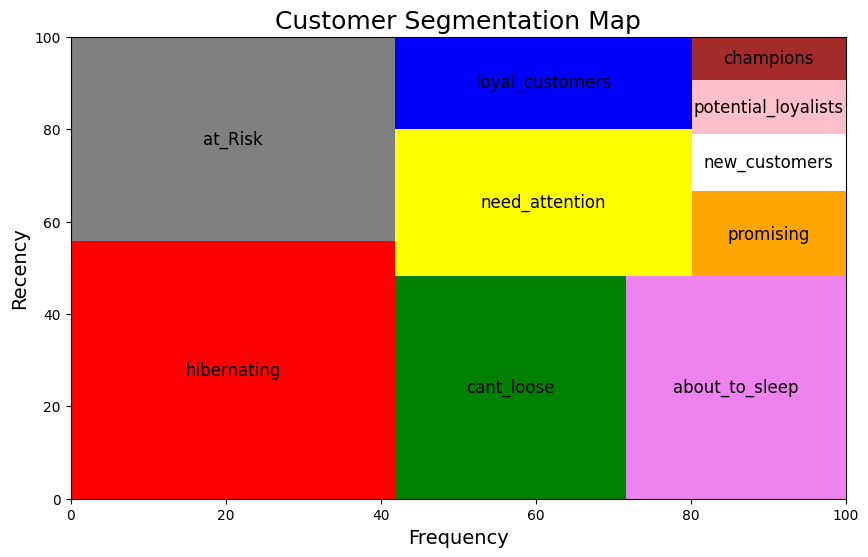

In [19]:
import squarify

customer_segments = rfm_naive['segment'].value_counts().sort_values(ascending = False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 6)
squarify.plot(sizes=customer_segments,
              label=[label for label in segment_map.values()],
              color=["red", "grey", "green", "violet", "yellow", "blue", "orange", "white", "pink", "brown"],
              pad = False,
              bar_kwargs = {'alpha': 1},
              text_kwargs = {'fontsize':12})
plt.title("Customer Segmentation Map", fontsize = 18)
plt.xlabel('Frequency', fontsize = 14)
plt.ylabel('Recency', fontsize = 14)
plt.show()

## 6 Clustering algorytms

#### 6.1 Functions

In [20]:
def elbow_method(X, max_range, method = 'KMeans'): 
    '''
    calculate elbow for differenmt algorytms and 'KMeans' is the default: 
    '''    
    from sklearn_extra.cluster import KMedoids
    from sklearn.cluster import KMeans
    
    inertias =[]
    for i in range(1,max_range+1):
        if method == 'KMeans':
            model = KMeans(n_clusters = i,init ='k-means++' ,random_state=42)
        elif method == 'KMedoids':
            model = KMedoids(n_clusters=i,random_state = 0, init = 'k-medoids++', metric='euclidean')
        else:
            print('something went wrong with the method')
            pass
        
        model.fit_predict(X)       
        inertias.append(model.inertia_)

    plt.title('Elbow Method for ' + method, fontsize = '18')
    plt.xlabel('No. of Clusters', fontsize = '14')
    plt.xticks(range(1,max_range+1), fontsize = '14')
    plt.ylabel('WCSS', fontsize = '14')
    plt.yticks(fontsize = '14')
    plt.plot(range(1,max_range+1),inertias)
    plt.show()
    
        
    pass 

def silhouette_(data, max_range, method = 'KMeans'):
    '''
    calculate elbow for differenmt algorytms and 'KMeans' is the default
    '''  
    list_ = []
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn_extra.cluster import KMedoids
    
    for i in range(2,max_range+1):
        if method == 'KMeans':
            model = KMeans(n_clusters = i,init ='k-means++' ,random_state=42)
        elif method == 'KMedoids':
            model = KMedoids(n_clusters=i, random_state = 42, init = 'k-medoids++', metric='euclidean')
        else:
            print('something went wrong with the method')
            break
        model.fit(data)       
        score = round(silhouette_score(data, model.predict(data), metric = 'euclidean'),3)
        print("for ", i, " clusters, the silhouette score is ", score)
        list_.append(score)
        
    return list_


def silhouette_visuals(data, clusters, method = 'KMeans'):
    '''
    '''
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn_extra.cluster import KMedoids

    from yellowbrick.cluster import SilhouetteVisualizer
    
    if method == 'KMeans':
        model = KMeans(n_clusters = clusters, init ='k-means++' ,random_state=42)
    elif method == 'KMedoids':
        model = KMedoids(n_clusters= clusters ,random_state = 42, init = 'k-medoids++', metric='euclidean')
    else:
        print('something went wrong with the method')
        pass
            
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(data)
    visualizer.show()
    plt.show()
    
    pass

#### 6.2 K-means and K-medoids

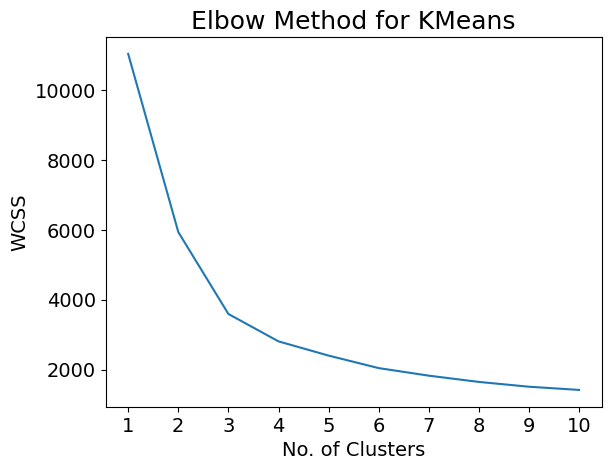

KMeans with 2 Clusters
Silhouette Score: 0.439
Davies Bouldin Index: 0.93
KMeans with 3 Clusters
Silhouette Score: 0.429
Davies Bouldin Index: 0.809


In [21]:
elbow_method(rfm_ss_no_irq, 10, method = 'KMeans') 

######################

print('KMeans with 2 Clusters')
labels_kmean_2 = KMeans(n_clusters = 2, init ='k-means++' , random_state=42).fit_predict(rfm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_kmean_2), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_kmean_2), 3)}')

######################

print('KMeans with 3 Clusters')
labels_kmean_3 = KMeans(n_clusters = 3, init ='k-means++' , random_state=42).fit_predict(rfm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(X, labels_kmean_3), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(X, labels_kmean_3), 3)}')


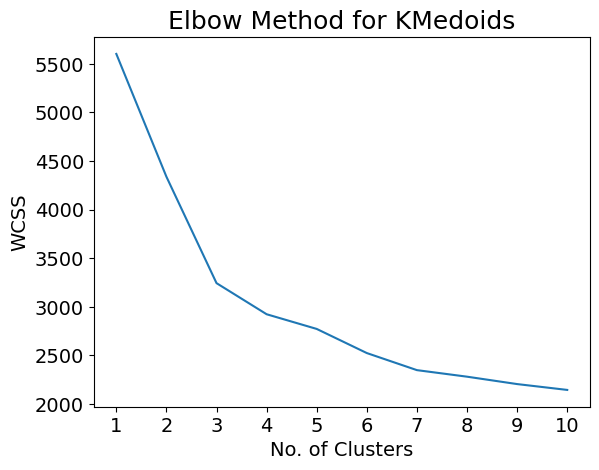

KMedoids with 3 Clusters
Silhouette Score: 0.425
Davies Bouldin Index: 0.816


In [22]:
elbow_method(rfm_ss_no_irq, 10, method = 'KMedoids')

######################

print('KMedoids with 3 Clusters')
labels_medoids = KMedoids(n_clusters = 3, init ='k-medoids++' , random_state=42, metric='euclidean').fit_predict(rfm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_medoids), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_medoids), 3)}')



#### 6.3 DBSCAN

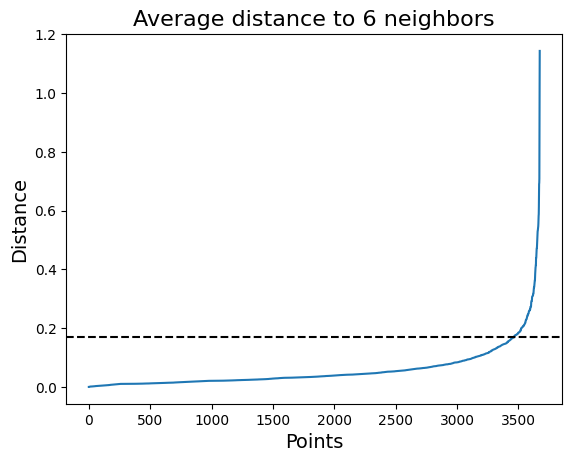

In [23]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(rfm_ss_no_irq)
distances, indices = neighbors_fit.kneighbors(rfm_ss_no_irq)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

#ploting results
plt.plot(distances)
plt.title('Average distance to 6 neighbors', fontsize = '16')
plt.ylabel('Distance', fontsize = '14')
plt.xlabel('Points', fontsize = '14')
plt.axhline(y=0.17, color='black', linestyle='--') #Espilon
plt.show()


In [24]:
labels_dbscan = DBSCAN(eps = 0.17, min_samples = 6, metric = 'euclidean').fit_predict(rfm_ss_no_irq)
print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_dbscan), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_dbscan), 3)}')


Silhouette Score: -0.237
Davies Bouldin Index: 1.684


#### 6.4 Hierarchical clustering

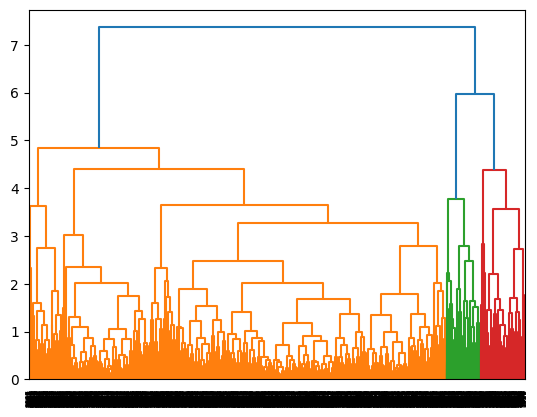

complete linkage with 3 Clusters
Silhouette Score: 0.378
Davies Bouldin Index: 0.971


In [26]:
mergings_ = linkage(rfm_ss_no_irq, method="complete", metric='euclidean')
dendrogram(mergings_)
plt.show()

print('complete linkage with 3 Clusters')
labels_linkage = cut_tree(mergings_, n_clusters=3).reshape(-1, )

print(f'Silhouette Score: {round(silhouette_score(rfm_ss_no_irq, labels_linkage), 3)}')
print(f'Davies Bouldin Index: {round(davies_bouldin_score(rfm_ss_no_irq, labels_linkage), 3)}')


### Step 7 Ploting final results


In [27]:
#coding naive segments by numbers instead of words
segment_map_new = {r'[1-2][1-2]': 1,
           r'[1-2][3-4]': 2,
           r'[1-2]5': 3,
           r'3[1-2]': 4,
           r'33': 5,
           r'[3-4][4-5]': 6,
           r'41': 7,
           r'51': 8,
           r'[4-5][2-3]': 9,
           r'5[4-5]': 9}

labels_naive = rfm_naive['RFM'].replace(segment_map_new, regex = True)


variance explained:  [0.6693366  0.90867829]


Text(0.5, 1.0, 'Naive')

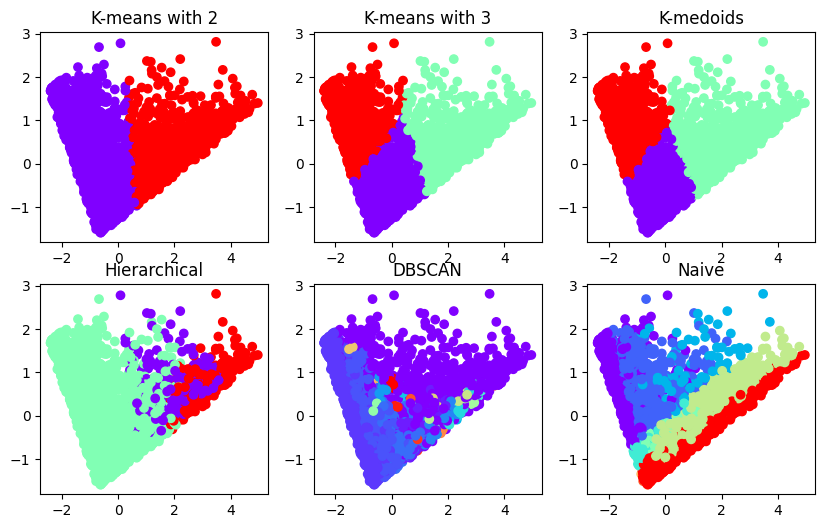

In [28]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(rfm_ss_no_irq)
print('variance explained: ', pca.explained_variance_ratio_.cumsum())

############

f, ax = plt.subplots(2,3,figsize=(10, 6))

ax[0,0].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_kmean_2, cmap='rainbow')
ax[0,0].set_title("K-means with 2")

ax[0,1].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_kmean_3, cmap='rainbow')
ax[0,1].set_title("K-means with 3")

ax[0,2].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_medoids, cmap='rainbow')
ax[0,2].set_title("K-medoids")


ax[1,0].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_linkage, cmap='rainbow')
ax[1,0].set_title("Hierarchical")

ax[1,1].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_dbscan , cmap='rainbow')
ax[1,1].set_title("DBSCAN")

ax[1,2].scatter(x=pca_2d[:,0], y=pca_2d[:,1], c = labels_naive, cmap='rainbow')
ax[1,2].set_title("Naive")

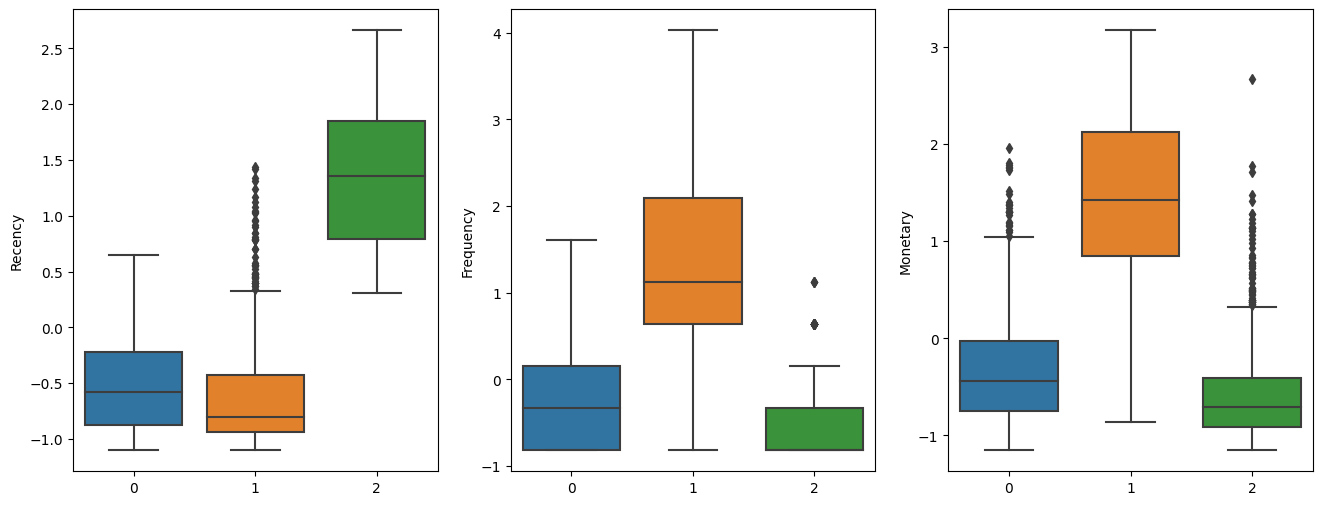

In [29]:
#visualize RFM by cluster labels

fig, ax = plt.subplots(1, 3, figsize=(16, 6))

features_ = ['Recency', 'Frequency', 'Monetary']

for i in range(3):
    
    sns.boxplot(ax=ax[i], x = labels_kmean_3, y=features_[i], data = rfm_ss_no_irq)
   
plt.show()